In [1]:
library(INLA)

Loading required package: Matrix

Loading required package: foreach

Loading required package: parallel

Loading required package: sp

This is INLA_22.05.07 built 2022-05-07 09:52:03 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - To enable PARDISO sparse library; see inla.pardiso()



In [2]:
n_arms = 4
y = c(0, 1, 9, 10)
n = c(20, 20, 35, 35)
mu_0 = -1.34
mu_sig2 = 100.0
sig2_alpha = 0.0005
sig2_beta = 0.000005
logit_p1 = rep(qlogis(0.3), n_arms)

In [3]:
names(inla.models()$latent$iid$hyper)

[1] "theta"

In [4]:
inla.models()$latent$iid$hyper$theta

$hyperid
[1] 1001
attr(,"inla.read.only")
[1] FALSE

$name
[1] "log precision"
attr(,"inla.read.only")
[1] FALSE

$short.name
[1] "prec"
attr(,"inla.read.only")
[1] FALSE

$prior
[1] "loggamma"
attr(,"inla.read.only")
[1] FALSE

$param
[1] 1e+00 5e-05
attr(,"inla.read.only")
[1] FALSE

$initial
[1] 4
attr(,"inla.read.only")
[1] FALSE

$fixed
[1] FALSE
attr(,"inla.read.only")
[1] FALSE

$to.theta
function (x) 
log(x)
<bytecode: 0x556982a5c110>
<environment: 0x556982a65d10>
attr(,"inla.read.only")
[1] TRUE

$from.theta
function (x) 
exp(x)
<bytecode: 0x556982a5bff8>
<environment: 0x556982a65d10>
attr(,"inla.read.only")
[1] TRUE

In [5]:
names(inla.models())

[1] "latent"     "group"      "mix"        "link"       "predictor" 
 [6] "hazard"     "likelihood" "prior"      "wrapper"    "lp.scale"

In [6]:
names(inla.models()$prior)

[1] "normal"                 "gaussian"               "linksnintercept"       
 [4] "wishart1d"              "wishart2d"              "wishart3d"             
 [7] "wishart4d"              "wishart5d"              "loggamma"              
[10] "gamma"                  "minuslogsqrtruncnormal" "logtnormal"            
[13] "logtgaussian"           "flat"                   "logflat"               
[16] "logiflat"               "mvnorm"                 "pc.alphaw"             
[19] "pc.ar"                  "dirichlet"              "none"                  
[22] "invalid"                "betacorrelation"        "logitbeta"             
[25] "pc.prec"                "pc.dof"                 "pc.cor0"               
[28] "pc.cor1"                "pc.fgnh"                "pc.spde.GA"            
[31] "pc.matern"              "pc.range"               "pc.sn"                 
[34] "pc.gamma"               "pc.mgamma"              "pc.gammacount"         
[37] "pc.gevtail"             "pc"                     "ref.ar"                
[40] "pom"                    "jeffreystdf"            "wishartkd"             
[43] "expression:"            "table:"

In [9]:
df <- data.frame(y = y, gid = (1:n_arms))
df

y,gid
<dbl>,<int>
0,1
1,2
9,3
10,4


In [10]:
# precision is inverse of sigma2.
# because we have an invgamma prior on sigma2, we want a gamma prior on the precision.

# do we need to deal with any change of variables nonsense here?
prec.prior <- list(prec = list(param = c(sig2_alpha, sig2_beta)))

In [11]:
gid_factor = as.factor(df[,'gid'])

In [12]:
# Run INLA with a model where
# logit(p) = intercept + random_effect(drawn iid from normal)
# The prior on the random effect influences the sharing between groups. I
# haven't tuned this yet.
result <- inla(
    y ~ logit_p1 + f(
        gid, 
        model = "iid",
        hyper = prec.prior
    ),
    data = df, 
    Ntrials = n,
    family = "binomial",
    control.compute = list(
        config = TRUE,
        return.marginals.predictor = TRUE
    ),
    control.inla = list(
        strategy=c("gaussian"),
        int.strategy=c("grid")
    )
)
summary(result)
# result.samp <- inla.posterior.sample(100, result)
# names(result.samp[[1]])
# print(result.samp[[1]])



Call:
   c("inla.core(formula = formula, family = family, contrasts = contrasts, 
   ", " data = data, quantiles = quantiles, E = E, offset = offset, ", " 
   scale = scale, weights = weights, Ntrials = Ntrials, strata = strata, 
   ", " lp.scale = lp.scale, link.covariates = link.covariates, verbose = 
   verbose, ", " lincomb = lincomb, selection = selection, control.compute 
   = control.compute, ", " control.predictor = control.predictor, 
   control.family = control.family, ", " control.inla = control.inla, 
   control.fixed = control.fixed, ", " control.mode = control.mode, 
   control.expert = control.expert, ", " control.hazard = control.hazard, 
   control.lincomb = control.lincomb, ", " control.update = 
   control.update, control.lp.scale = control.lp.scale, ", " 
   control.pardiso = control.pardiso, only.hyperparam = only.hyperparam, 
   ", " inla.call = inla.call, inla.arg = inla.arg, num.threads = 
   num.threads, ", " blas.num.threads = blas.num.threads, keep = keep, 


In [13]:
names(result)

[1] "names.fixed"                 "summary.fixed"              
 [3] "marginals.fixed"             "summary.lincomb"            
 [5] "marginals.lincomb"           "size.lincomb"               
 [7] "summary.lincomb.derived"     "marginals.lincomb.derived"  
 [9] "size.lincomb.derived"        "mlik"                       
[11] "cpo"                         "gcpo"                       
[13] "po"                          "waic"                       
[15] "model.random"                "summary.random"             
[17] "marginals.random"            "size.random"                
[19] "summary.linear.predictor"    "marginals.linear.predictor" 
[21] "summary.fitted.values"       "marginals.fitted.values"    
[23] "size.linear.predictor"       "summary.hyperpar"           
[25] "marginals.hyperpar"          "internal.summary.hyperpar"  
[27] "internal.marginals.hyperpar" "offset.linear.predictor"    
[29] "model.spde2.blc"             "summary.spde2.blc"          
[31] "marginals.spde2.blc"         "size.spde2.blc"             
[33] "model.spde3.blc"             "summary.spde3.blc"          
[35] "marginals.spde3.blc"         "size.spde3.blc"             
[37] "logfile"                     "misc"                       
[39] "dic"                         "mode"                       
[41] "joint.hyper"                 "nhyper"                     
[43] "version"                     "Q"                          
[45] "graph"                       "ok"                         
[47] "cpu.used"                    "all.hyper"                  
[49] ".args"                       "call"                       
[51] "model.matrix"

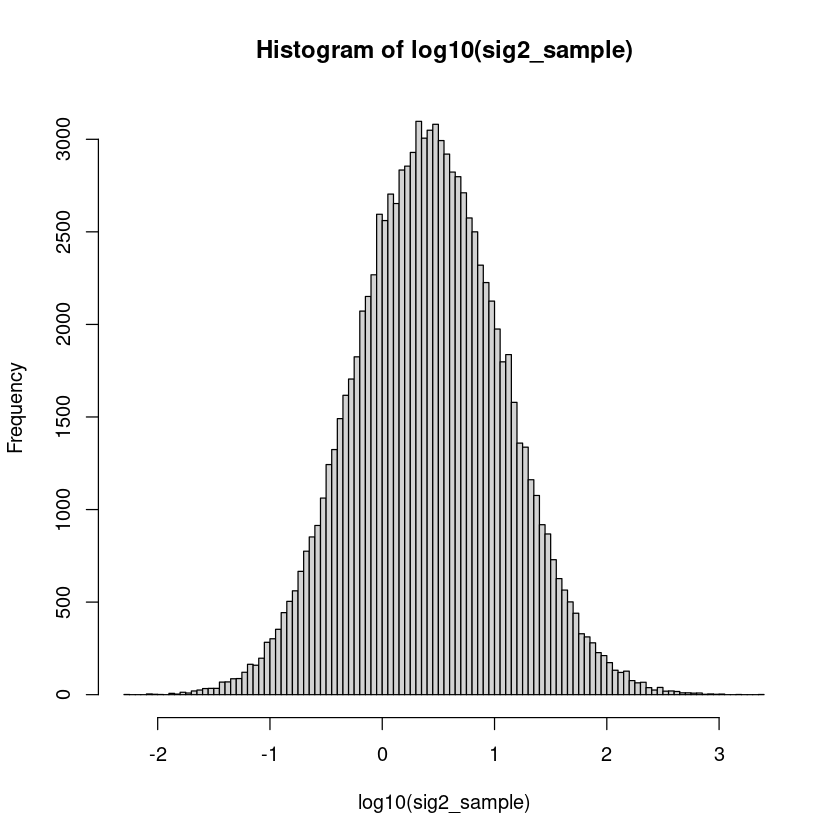

In [14]:
sig2_sample = 1.0 / inla.hyperpar.sample(n=100000, result)
hist(log10(sig2_sample), breaks = 100)

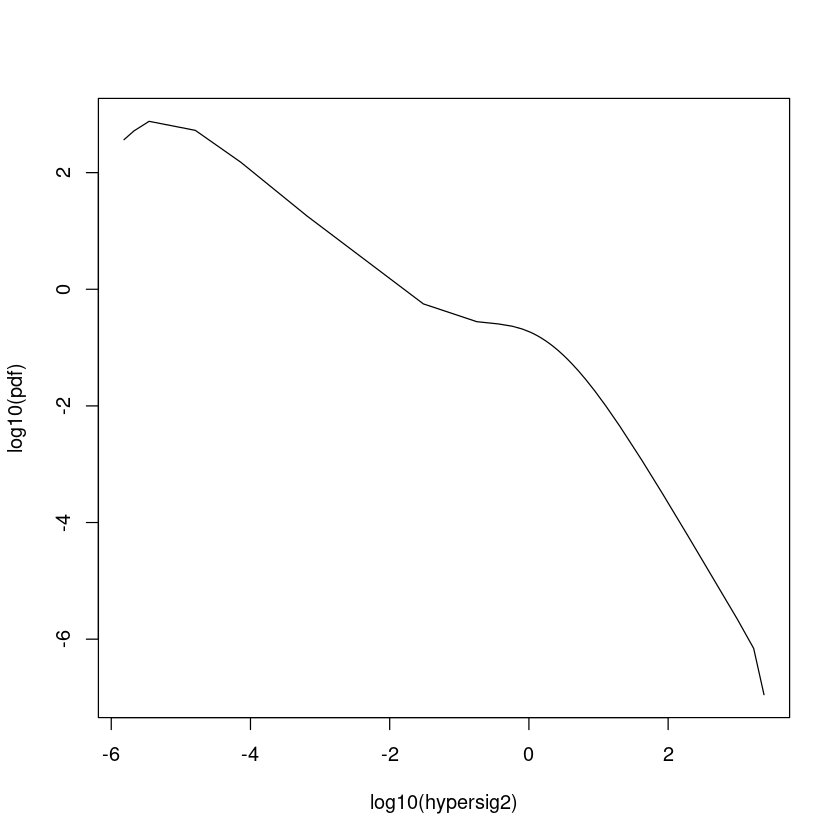

In [18]:
hyperpar_data = result$marginals.hyperpar
hyperprec = hyperpar_data[[1]][, 'x']
hypersig2 = 1.0 / hyperprec
pdf = hyperpar_data[[1]][, 'y'] / hypersig2^2
plot(log10(hypersig2), log10(pdf), type = "l")

In [45]:
inla.hyperpar(result)

Warning message in inla.hyperpar(result):
“inla.hyperpar: This function is deprecated, please do not use.”


Call:
   c("inla.core(formula = formula, family = family, contrasts = contrasts, 
   ", " data = data, quantiles = quantiles, E = E, offset = offset, ", " 
   scale = scale, weights = weights, Ntrials = Ntrials, strata = strata, 
   ", " lp.scale = lp.scale, link.covariates = link.covariates, verbose = 
   verbose, ", " lincomb = lincomb, selection = selection, control.compute 
   = control.compute, ", " control.predictor = control.predictor, 
   control.family = control.family, ", " control.inla = control.inla, 
   control.fixed = control.fixed, ", " control.mode = control.mode, 
   control.expert = control.expert, ", " control.hazard = control.hazard, 
   control.lincomb = control.lincomb, ", " control.update = 
   control.update, control.lp.scale = control.lp.scale, ", " 
   control.pardiso = control.pardiso, only.hyperparam = only.hyperparam, 
   ", " inla.call = inla.call, inla.arg = inla.arg, num.threads = 
   num.threads, ", " blas.num.threads = blas.num.threads, keep = keep, 
 

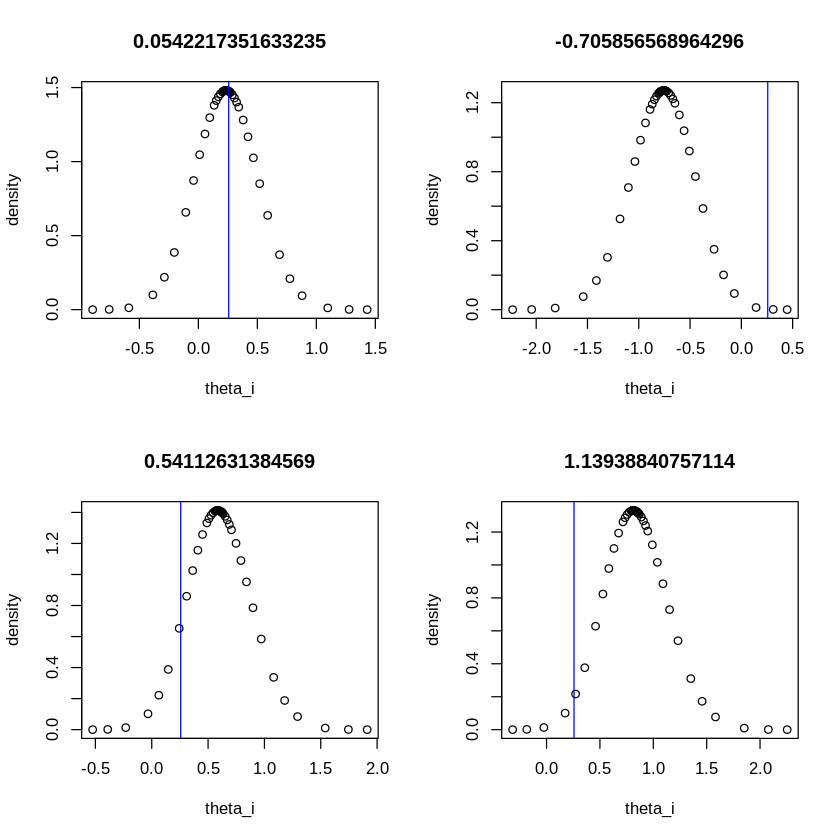

In [4]:
# Plot marginal PDFs.
# These will depend heavily on hyperparameter priors which I have just left
# default for now.
par(mfrow=c(2,2))
for (i in 1:n_groups) {
    theta_i <- result$marginals.linear.predictor[[i]][,1]
    density <- result$marginals.linear.predictor[[i]][,2]
    plot(theta_i, density, main=t_i[[i]])
    abline(v=mean(t_i), col="blue")
}

In [5]:
# Print 95% confidence intervals for the linear predictors. 
# I'm not 100% sure these are correct, but they track correctly with the y_i
for (i in 1:n_groups) {
    print(t_i[[i]])
    print(inla.hpdmarginal(0.95, result$marginals.linear.predictor[[i]]))
}

[1] 0.05422174
                  low      high
level:0.95 -0.2912725 0.7715989
[1] -0.7058566
                 low       high
level:0.95 -1.398296 -0.1607867
[1] 0.5411263
                  low     high
level:0.95 0.05131246 1.165621
[1] 1.139388
                 low     high
level:0.95 0.2552132 1.437339


In [6]:
for (i in 1:n_groups) {
    print(y_i[[i]])
    print(inla.pmarginal(0, result$marginals.linear.predictor[[i]]))
}

[1] 28
[1] 0.1887528
[1] 14
[1] 0.9950012
[1] 33
[1] 0.01385696
[1] 36
[1] 0.001383654
